In [1]:
import pandas as pd
import time
import nibabel as nb
from nilearn import plotting as plot
from nilearn import image as img
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as nd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


In [2]:
df = pd.read_excel("ATR_GT_Training_og.xlsx",header = None, names=['File Name','Label'])
df['File Name'] = df['File Name'].map(lambda x: x.lstrip("'").rstrip("'"))
df['Image'] = df['File Name'].map(lambda x: nb.load('ATR_data/' + str(x) + '.nii.gz'))

In [3]:
feature_stats = np.load('stat_features.npy')
feature_histogram = np.load('features_histogram.npy')
features = np.concatenate((feature_stats,feature_histogram),axis=1)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = features[:1005]
y = df.Label[:1005]

#standarize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,train_size = 0.8,test_size = 0.2, random_state = 10)



In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold

#Testing on multiple models
clfs = []
#C = 5 is good optimization parameter to keep the misclassification rate lower and keep the hyperplane classifying point correcly
svm = SVC(kernel='linear', C=5)
clfs.append([svm,'Support Vector Machine'])
lr = LogisticRegression(random_state = 0, solver = 'lbfgs',multi_class='multinomial')
clfs.append([lr,'Logistic Regression'])
ada = AdaBoostClassifier(n_estimators=100)
clfs.append([ada,'AdaBoost'])
knn = KNeighborsClassifier(n_neighbors = 3)
clfs.append([knn,'K-Neighbors'])


In [6]:
from sklearn.metrics import accuracy_score

svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)

lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)

knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)


print("Support Vector Machine\nAccuracy: ", accuracy_score(y_test, svm_pred))
print("Logistic Regression\nAccuracy: ", accuracy_score(y_test, lr_pred))
print("AdaBoost Classifier\nAccuracy: ", accuracy_score(y_test, ada_pred))
print("K-Nearest Neighbor\nAccuracy: ", accuracy_score(y_test, knn_pred))


Support Vector Machine
Accuracy:  0.7611940298507462
Logistic Regression
Accuracy:  0.7761194029850746
AdaBoost Classifier
Accuracy:  0.6069651741293532
K-Nearest Neighbor
Accuracy:  0.835820895522388


In [7]:
from sklearn.metrics import classification_report

print('Support Vector Machine Classification Report: \n', classification_report(y_test, svm_pred))
print('Logistic Regression Classification Report: \n', classification_report(y_test, lr_pred))
print('AdaBoost Classifier Classification Report: \n', classification_report(y_test, ada_pred))
print('K-Nearest Neighbors Classification Report: \n', classification_report(y_test, knn_pred))

Support Vector Machine Classification Report: 
               precision    recall  f1-score   support

         0.0       0.77      0.95      0.85       146
         1.0       0.00      0.00      0.00        14
         2.0       0.77      0.37      0.50        27
         3.0       0.50      0.29      0.36        14

    accuracy                           0.76       201
   macro avg       0.51      0.40      0.43       201
weighted avg       0.70      0.76      0.71       201

Logistic Regression Classification Report: 
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       146
         1.0       0.33      0.07      0.12        14
         2.0       0.82      0.52      0.64        27
         3.0       0.50      0.29      0.36        14

    accuracy                           0.78       201
   macro avg       0.61      0.45      0.49       201
weighted avg       0.74      0.78      0.74       201

AdaBoost Classifier Classification Re

In [18]:
from sklearn.model_selection import GridSearchCV

leaf_size = list(range(1,30))
num_neigh = list(range(1,10))
power = [1,2]

hp_knn = dict(leaf_size = leaf_size, n_neighbors = num_neigh, p = power)

knn_new = KNeighborsClassifier()

grid_knn = GridSearchCV(knn_new, hp_knn, cv = 10)

best_param_knn = grid_knn.fit(X_train,y_train)

print('Best leaf_size:', best_param_knn.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_param_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_param_knn.best_estimator_.get_params()['n_neighbors'])


Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [18]:
knn_best = KNeighborsClassifier(n_neighbors = 1, leaf_size = 1, p=1)

knn_best.fit(X_train,y_train)
knn_best_pred = knn_best.predict(X_test)

print("K-Nearest Neighbor\nAccuracy: ", accuracy_score(y_test, knn_best_pred))
print("Classification Report: \n", classification_report(y_test,knn_best_pred))

K-Nearest Neighbor
Accuracy:  0.8756218905472637
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91       146
         1.0       0.69      0.79      0.73        14
         2.0       0.83      0.74      0.78        27
         3.0       0.75      0.86      0.80        14

    accuracy                           0.88       201
   macro avg       0.80      0.82      0.81       201
weighted avg       0.88      0.88      0.88       201



In [11]:
knn_precision = precision_score(y_test,knn_best_pred,average='macro')
knn_recall = recall_score(y_test, knn_best_pred,average='macro')
knn_f1 = f1_score(y_test,knn_best_pred,average='macro')

print("K-Nearest Neighbor\nPrecision Rate: ", knn_precision)
print("K-Nearest Neighbor\nRecall Rate: ", knn_recall)
print("K-Nearest Neighbor\nF1-Score: ", knn_f1)

K-Nearest Neighbor
Precision Rate:  0.7970186781609195
K-Nearest Neighbor
Recall Rate:  0.8236391969268682
K-Nearest Neighbor
F1-Score:  0.8079341014756417


In [12]:
#Generating Co-Matrix for each model
from sklearn.metrics import confusion_matrix

svm_comatrix = confusion_matrix(y_test, svm_pred)
lr_comatrix = confusion_matrix(y_test, lr_pred)
ada_comatrix = confusion_matrix(y_test, ada_pred)
knn_comatrix = confusion_matrix(y_test, knn_best_pred)

targets = list(set(y_train))

svm_matrix = np.mat(svm_comatrix) 
lr_matrix = np.mat(lr_comatrix)
ada_matrix = np.mat(ada_comatrix)
knn_matrix = np.mat(knn_comatrix)

svm_cm = pd.DataFrame(svm_matrix,index = targets, columns = targets)
lr_cm = pd.DataFrame(lr_matrix,index = targets, columns = targets)
ada_cm = pd.DataFrame(ada_matrix,index = targets, columns = targets)
knn_cm = pd.DataFrame(knn_matrix,index = targets, columns = targets)
knn_cm

,0.0,1.0,2.0,3.0
0.0,133,5,4,4
1.0,3,11,0,0
2.0,7,0,20,0
3.0,2,0,0,12


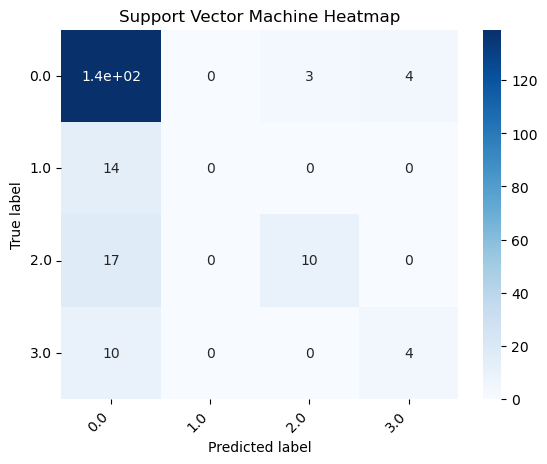

In [59]:
#Generate heatmaps for each model

#Heatmap for SVM
import seaborn as sns
plt.figure()

heatmap = sns.heatmap(svm_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Support Vector Machine Heatmap')
plt.show() 

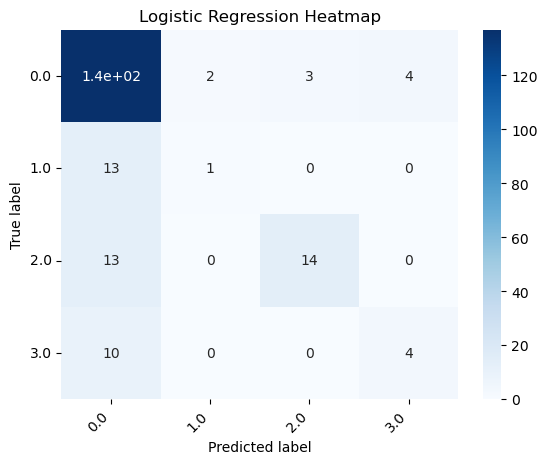

<Figure size 640x480 with 0 Axes>

In [56]:
plt.figure()
heatmap = sns.heatmap(lr_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Logistic Regression Heatmap')
plt.show()

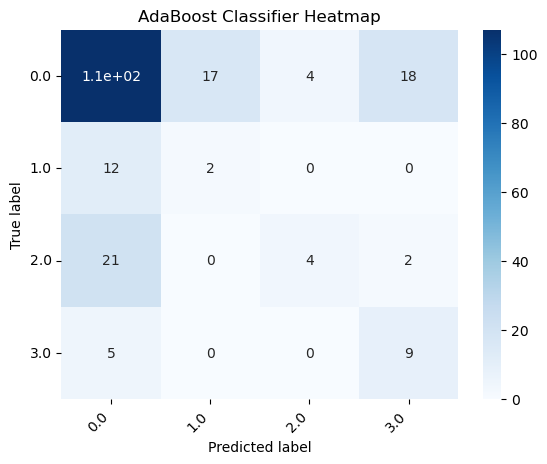

In [58]:
plt.figure()

heatmap = sns.heatmap(ada_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('AdaBoost Classifier Heatmap')
plt.show() 

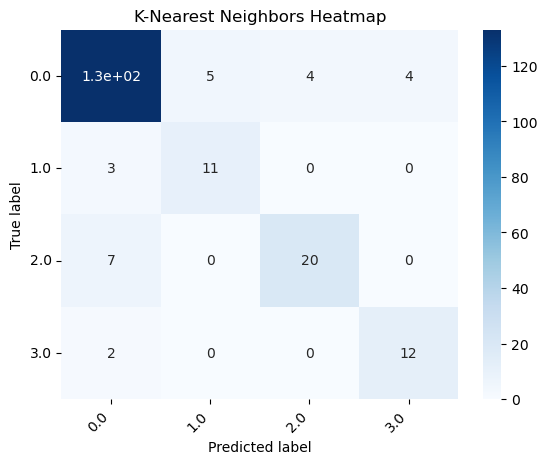

In [13]:
plt.figure()

heatmap = sns.heatmap(knn_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('K-Nearest Neighbors Heatmap')
plt.show() 

In [52]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Get the Precision Score for each model
#Measure the proportion of positively predicted labels that are actually correct

svm_precision = precision_score(y_test,svm_pred,average='weighted')
lr_precision = precision_score(y_test,lr_pred,average='weighted')
ada_precision = precision_score(y_test,ada_pred,average='weighted')
knn_precision = precision_score(y_test,knn_pred,average='weighted')

print("Support Vector Machine\nPrecision Rate: ", svm_precision)
print("Logistic Regression\nPrecision Rate: ", lr_precision)
print("AdaBoost Classifier\nPrecision Rate: ", ada_precision)
print("K-Nearest Neighbor\nPrecision Rate: ", knn_precision)

Support Vector Machine
Precision Rate:  0.6990730110133095
Logistic Regression
Precision Rate:  0.7438828750952254
AdaBoost Classifier
Precision Rate:  0.6321216061254527
K-Nearest Neighbor
Precision Rate:  0.8433463635956259


C:\Users\Cassa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
#Get the Recall score for each model
svm_recall = recall_score(y_test, svm_pred,average='weighted')
lr_recall = recall_score(y_test, lr_pred,average='weighted')
ada_recall = recall_score(y_test, ada_pred,average='weighted')
knn_recall = recall_score(y_test, knn_pred,average='weighted')

print("Support Vector Machine\nRecall Rate: ", svm_recall)
print("Logistic Regression\nRecall Rate: ", lr_recall)
print("AdaBoost Classifier\nRecall Rate: ", ada_recall)
print("K-Nearest Neighbor\nRecall Rate: ", knn_recall)

Support Vector Machine
Recall Rate:  0.7611940298507462
Logistic Regression
Recall Rate:  0.7761194029850746
AdaBoost Classifier
Recall Rate:  0.6069651741293532
K-Nearest Neighbor
Recall Rate:  0.835820895522388


In [54]:
#Get the F1 Score for each model
svm_f1 = f1_score(y_test,svm_pred,average='weighted')
lr_f1 = f1_score(y_test,lr_pred,average='weighted')
ada_f1 = f1_score(y_test,ada_pred,average='weighted')
knn_f1 = f1_score(y_test,knn_pred,average='weighted')

print("Support Vector Machine\nF1-Score: ", svm_f1)
print("Logistic Regression\nF1-Score: ", lr_f1)
print("AdaBoost Classifier\nF1-Score: ", ada_f1)
print("K-Nearest Neighbor\nF1-Score: ", knn_f1)

Support Vector Machine
F1-Score:  0.7119103312217497
Logistic Regression
F1-Score:  0.7429063423432349
AdaBoost Classifier
F1-Score:  0.6024704526327317
K-Nearest Neighbor
F1-Score:  0.8354608575435103


In [22]:
knn_bin_pred = []
knn_bin_test = []
for x in knn_best_pred:
    if x == 1.0 or x == 2.0 or x == 3.0:
        knn_bin_pred.append(1)
    else:
        knn_bin_pred.append(0)
        
for x in y_test:
    if x == 1.0 or x == 2.0 or x == 3.0:
        knn_bin_test.append(1)
    else:
        knn_bin_test.append(0)
    
print(y_test)
print(knn_bin_test)

965    0.0
647    0.0
568    0.0
800    3.0
280    0.0
      ... 
846    0.0
948    0.0
739    0.0
581    3.0
558    0.0
Name: Label, Length: 201, dtype: float64
[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [25]:
bin_targets = list(set(knn_bin_test))

knn_bin_comatrix = confusion_matrix(knn_bin_test, knn_bin_pred)
knn_bin_matrix = np.mat(knn_bin_comatrix)
knn_bin_cm = pd.DataFrame(knn_bin_matrix,index = bin_targets, columns = bin_targets)
knn_bin_cm

,0,1
0,133,13
1,12,43


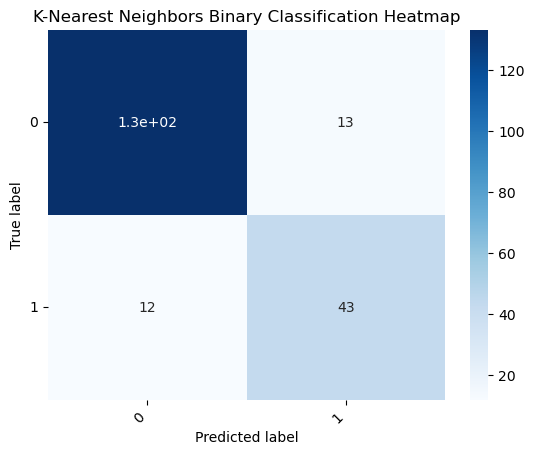

In [26]:
plt.figure()

heatmap = sns.heatmap(knn_bin_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('K-Nearest Neighbors Binary Classification Heatmap')
plt.show() 